This notebook uses data.x1 (23 features) to do individual sphase prediction.

In [1]:
import data1 as data
import random
from common import *
from rules import *
from realkd.patch import RuleFit
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.colors as mcolors


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Individual phase prediction


In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM

STATE = np.random.RandomState(seed=1000)

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)
lr_ind = BinaryRelevanceClassifier(lr)

# gams not fixed, remove this part.
# gam_ind = BinaryRelevanceClassifier(LogisticGAM(lam=20.0, max_iter=250))
gam = LogisticGAM(lam=[80.0]*len(data.x1.columns), max_iter=250)

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)
rf_ind = BinaryRelevanceClassifier(rf)

# Rulefit
rufit = RuleFitWrapper()

indi_estimators = [lr, gam, rf, rufit]
indi_names = ['LR', 'GAM','RanF', 'RuFit']

This following code under "2.6 GHz 6-Core Intel Core i7" runs ~5 hours. You can simply use saved result to re-run the result.

In [ ]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold

inter_no_comp = {}

print('Num of predictors:, ', data.x1.shape[1])
for y in [data.sphere, data.vesicle, data.worm]: # miss other
    print('Target: ',y.name)
    if y,name != data.worm:
        experiment = Experiment(indi_estimators, 
                            indi_names,
                            KFold(30, shuffle=True, random_state=STATE),
                            data.x1, y.replace(-1, 0),
                            groups=data.comp_ids.array, 
                            evaluators=['accuracy', LogLikelihoodEvaluator()],
                            verbose=True)
    else:
        Experiment([lr, rf, rufit], 
                        ['LR','RanF', 'RuFit'],
                        KFold(30, shuffle=True, random_state=STATE),
                        data.x1, data.other.replace(-1, 0),
                        groups=data.comp_ids.array, 
                        evaluators=['accuracy', LogLikelihoodEvaluator()],
                        verbose=True)
    inter_no_comp[y.name] = experiment.run()
    print()

In [13]:
# import pickle
# with open('interpolation_iid_23.pkl', 'wb') as f:   
#     pickle.dump(inter_no_comp, f)

In [8]:
import pickle
cur_save=open('./' + 'interpolation_iid_23' + '.pkl', 'rb')
inter_no_comp = pickle.load(cur_save)

In [14]:
def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)
    
inter_no_comp_df = {}
for key in inter_no_comp:
    df = inter_no_comp[key].summary()
    df['mean_train_error'] = 1- df['mean_train_accuracy']
    df['std_train_error'] = df['std_train_accuracy']
    df['mean_test_error'] = 1- df['mean_test_accuracy']
    df['std_test_error'] = df['std_test_accuracy']
    inter_no_comp_df[key] = df

In [15]:
# get base line 
# error
informed_error = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = cnt/sum(cnt)
    informed_error.append((1-max(prob)))
print('Informed error: ', informed_error)

uniformed_error = [0.5, 0.5, 0.5, 0.5]
print('Uninformed error: ', uniformed_error)

Informed error:  [0.46283783783783783, 0.2922297297297297, 0.33783783783783783, 0.02533783783783783]
Uninformed error:  [0.5, 0.5, 0.5, 0.5]


In [16]:
inter_no_comp_df['sphere']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log likelihood,std_train_log likelihood,mean_test_log likelihood,std_test_log likelihood,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.537163,0.004021,0.537982,0.116531,-0.680834,0.001276,-0.684561,0.036543,0.462837,0.004021,0.462018,0.116531
GAM,0.894527,0.062588,0.864649,0.076803,-0.261244,0.014434,-0.564133,0.822524,0.105473,0.062588,0.135351,0.076803
RanF,1.000000,0.000000,0.917456,0.062261,-0.059016,0.001503,-0.280355,0.312304,0.000000,0.000000,0.082544,0.062261
RuFit,0.984739,0.004326,0.917632,0.054837,-0.076994,0.004804,-0.247580,0.160031,0.015261,0.004326,0.082368,0.054837


In [17]:
inter_no_comp_df['vesicle']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log likelihood,std_train_log likelihood,mean_test_log likelihood,std_test_log likelihood,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.707712,0.002885,0.707456,0.081399,-0.596996,0.002170,-0.599474,0.062406,0.292288,0.002885,0.292544,0.081399
GAM,0.934937,0.002548,0.910263,0.052556,-0.165655,0.002979,-0.223156,0.129074,0.065063,0.002548,0.089737,0.052556
RanF,1.000000,0.000000,0.922193,0.056414,-0.052196,0.001544,-0.201495,0.094749,0.000000,0.000000,0.077807,0.056414
RuFit,0.990272,0.003546,0.905526,0.055898,-0.063605,0.003807,-0.205239,0.118165,0.009728,0.003546,0.094474,0.055898


In [18]:
inter_no_comp_df['worm']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log likelihood,std_train_log likelihood,mean_test_log likelihood,std_test_log likelihood,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.633213,0.010944,0.630614,0.107999,-0.580565,0.002512,-0.583264,0.073275,0.366787,0.010944,0.369386,0.107999
GAM,0.856477,0.003913,0.827632,0.057359,-0.322791,0.003595,-0.368289,0.104745,0.143523,0.003913,0.172368,0.057359
RanF,1.000000,0.000000,0.909211,0.068095,-0.058065,0.001486,-0.266352,0.380182,0.000000,0.000000,0.090789,0.068095
RuFit,0.986776,0.004655,0.899035,0.060747,-0.074509,0.004109,-0.255161,0.170302,0.013224,0.004655,0.100965,0.060747


sphere 



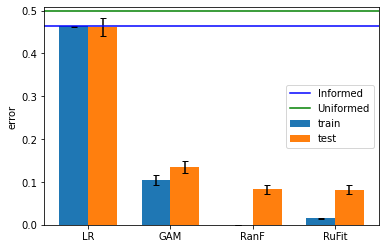

vesicle 



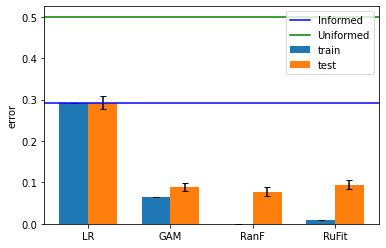

worm 



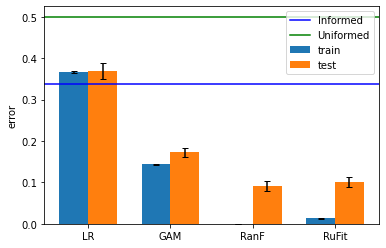

other 



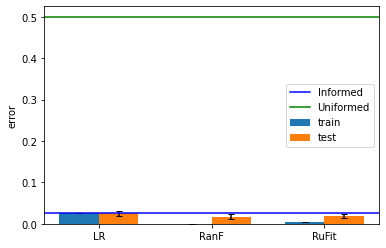

In [19]:
i = 0
for key in inter_no_comp_df:
    print(key, '\n')
    line = [informed_error[i], uniformed_error[i]]
    plot_summary('error', summ=inter_no_comp_df[key], baseline=line, names=['Informed', 'Uniformed'])
    i += 1
    plt.show()

__Log likelihood__

All the estimators performs much better than random guessing and informed guessing.

In [20]:
# get base line 
# log loss
informed_loglikelihood = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = cnt/sum(cnt)
    informed_loglikelihood.append(sum(1*prob * np.log2(prob)))
print('Informed loglikelihood: ', informed_loglikelihood)

uniformed_loglikelihood = [1*0.5 * np.log2(0.5)*2] * 4
print('Uninformed loglikelihood: ', uniformed_loglikelihood)

Informed loglikelihood:  [-0.9960115235485287, -0.8715841441742509, -0.9227346209530941, -0.17044317741514714]
Uninformed loglikelihood:  [-1.0, -1.0, -1.0, -1.0]


sphere 



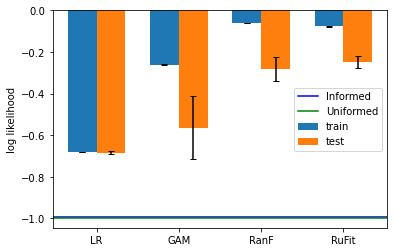

vesicle 



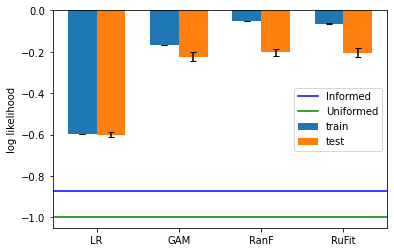

worm 



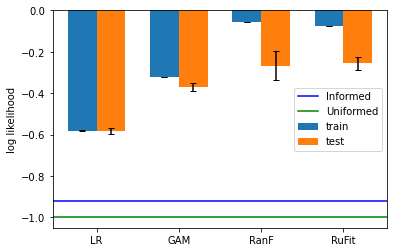

other 



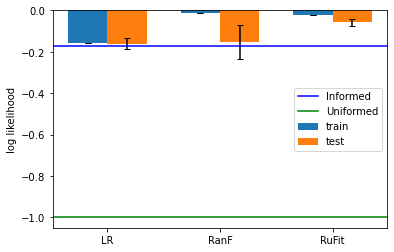

In [21]:
i = 0
for key in inter_no_comp_df:
    print(key, '\n')
    line = [informed_loglikelihood[i], uniformed_loglikelihood[i]]
    plot_summary('log likelihood', summ=inter_no_comp_df[key], baseline=line, names=['Informed', 'Uniformed'])
    i += 1
    plt.show()

In [22]:
def loss(y_test, y_pred):
    y_test = y_test.astype(np.float16)
    y_pred = y_pred.astype(np.float16)
    if len(y_test.shape) == 1:
        N = y_test.shape[0]
        loss = 0
        for i in range(N):
            loss -= ((y_test[i]*np.log(y_pred[i]))+((1.0-y_test[i])*np.log(1.0-y_pred[i])))
            loss = loss/N
    else:
        N,M = y_test.shape
        a=[]
        for m in range(M):
            loss=0
            for i in range(N):
                subloss = ((y_test[i,m]*np.log(y_pred[i,m]))+((1.0-y_test[i,m])*np.log(1.0-y_pred[i,m])))
                if np.isnan(subloss):
                    continue
                loss -= subloss
            loss = loss/N
            a.append(round(loss,8))
        loss = np.mean(a)
    return loss

In [23]:
# choose the best RuleFit
best_rf = {}
for phase in inter_no_comp:
    lst = []
    for each in inter_no_comp[phase].fitted_['RuFit']:
        pred = each.predict_proba(data.x)
        res = log_loss(data.y[phase].values, pred)
        lst.append((res, each))
    lst.sort()
    best_rf[phase] = lst[0][1]

In [24]:
for each in best_rf:
    dic = best_rf[each].get_rules(data.x, data.y[each])
    for key, values in dic.items():
        name = 'Rules/Individual_Phase/Interpolation/23p'+ "_" + key + '.csv'
        values.to_csv(name, index=False)